<div align="center"> <h3>Data overview</h3> </div>

##### Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

##### Output the number of files and the first five file names in each of these directories.

In [2]:
base_dir = 'DataSet'

train_dir = base_dir + '/train_v2/'
test_dir = base_dir + '/test_v2/'

In [3]:
train = os.listdir(train_dir)
test = os.listdir(test_dir)

print(f"Train files: {len(train)}: \n {train[:5]}")
print(f"Test files :  {len(test)}: \n {test[:5]}")

Train files: 192556: 
 ['db4d6ecd4.jpg', '4be1d7b76.jpg', '6961eaf60.jpg', 'd0b573bd5.jpg', '2702aee48.jpg']
Test files :  15606: 
 ['c677b923d.jpg', '70f933b1a.jpg', '6efd40b2c.jpg', '75004aaf3.jpg', '7ae269875.jpg']


In [4]:
train;

In [5]:
test;

##### Read the sample_submision_v2.csv file to examine the structure of the dataframes.

In [6]:
submission_example = pd.read_csv('dataset/sample_submission_v2.csv')

In [7]:
submission_example.head(10);

In [8]:
submission_example.describe();

##### We begin by reading the CSV file train_ship_segmentations_v2.csv, which contains information about ship masks. Next, we create a boolean series called not_empty, determining whether the EncodedPixels values (information about ship mask on images) are marked as non-NaN.

##### Subsequently, we output statistics regarding the number of masks and images. The first output displays the count of non-empty masks and the number of unique images with ships present. The second output reveals the count of empty images (without ships) and the total number of unique images in the entire dataset.

In [9]:
ship_segmentations = pd.read_csv('dataset/train_ship_segmentations_v2.csv')
not_empty = pd.notna(ship_segmentations.EncodedPixels)
print(not_empty.sum(), 'masks in', ship_segmentations[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', ship_segmentations.ImageId.nunique(), 'total images')

81723 masks in 42556 images
150000 empty images in 192556 total images


In [10]:
ship_segmentations.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [11]:
ship_segmentations.describe();

##### Now lets see the class balance if we mark with label '1' those rows that have non-null value for 'EncodedPixels' column and '0' for null values of this column.

In [12]:
ship_segmentations['Category'] = ship_segmentations['EncodedPixels'].notna().astype(int)

In [13]:
ship_segmentations.head()

,ImageId,EncodedPixels,Category
0,00003e153.jpg,NaN,0
1,0001124c7.jpg,NaN,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1


In [14]:
result = ship_segmentations.groupby('ImageId')['Category'].mean().value_counts(normalize=True)


In [15]:
result

Category
0.0    0.778994
1.0    0.221006
Name: proportion, dtype: float64

##### From the data analysis, it is evident that in approximately 77.9% of the photos, ships are absent (Category 0.0), while in the remaining 22.1% of the photos, ships are present (Category 1.0). Thus, the majority of images in your dataset do not contain ships, whereas a smaller but significant portion depicts the presence of ships.

##### Calculating the total number of ships in each image.

In [16]:
ship_segmentations['ships'] = ship_segmentations['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = ship_segmentations.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
ship_segmentations.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


##### Let's create graphical visualizations, such as a histogram and a pie chart, to explore the distribution of the number of ships in images. This will provide us with more insights and help define a strategy for optimizing model training on samples with ships and a small portion of images without ships.

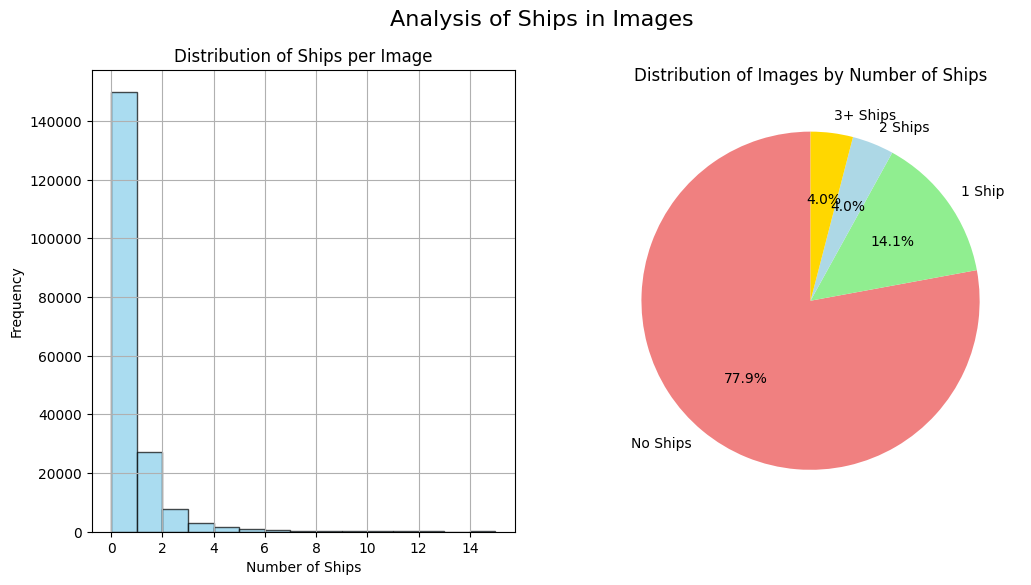

Max number of ships: 15, Average number of ships: 0.42


In [17]:
# Histogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ships_hist = unique_img_ids['ships']
ships_hist.hist(bins=ships_hist.max(), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Ships per Image')
plt.xlabel('Number of Ships')
plt.ylabel('Frequency')

# Pie Chart
plt.subplot(1, 2, 2)
ship_count_hist = ships_hist.value_counts().sort_index()

categories = ['No Ships', '1 Ship', '2 Ships', '3+ Ships']
sizes = [
    ship_count_hist[0] if 0 in ship_count_hist.index else 0,
    ship_count_hist[1] if 1 in ship_count_hist.index else 0,
    ship_count_hist[2] if 2 in ship_count_hist.index else 0,
    ship_count_hist[3:].sum() if len(ship_count_hist) > 3 else 0
]

colors = ['lightcoral', 'lightgreen', 'lightblue', 'gold']
plt.pie(sizes, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Images by Number of Ships')

plt.suptitle('Analysis of Ships in Images', fontsize=16)
plt.show()

# Statistics
print('Max number of ships: {}, Average number of ships: {:.2f}'.format(ships_hist.max(), ships_hist.mean()))


##### This visualization indicates that our dataset follows a distribution where images containing no ships are approximately three times more abundant than those with ships. As a takeaway for future endeavors, it suggests a strategy for training models using samples that predominantly feature ships, with only a small portion dedicated to images without ships. This approach aims to optimize the model's ability to effectively address the segmentation problem.

##### Let's load and visualize an image.

In [18]:
image_path = f"dataset/train_v2/000155de5.jpg"

In [19]:
img = plt.imread(image_path)

In [20]:
print("Shape of the image:", img.shape)


Shape of the image: (768, 768, 3)


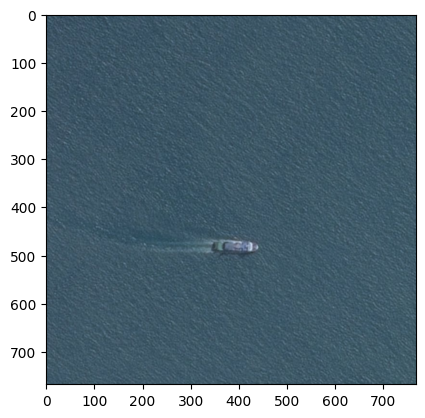

In [21]:
plt.imshow(img)
plt.show()

##### Let's check if all the pictures in test dataset have the same width and height in pixels. We will check it only on the test set because the train dataset has too many images. I think we can say that the images have the same size even if we look only at the test dataset.

In [22]:
base_path = "dataset/test_v2/"

In [ ]:
one_shape = None

for image_title in test:
    try:
        img_path = os.path.join(base_path, str(image_title))
        img_shape = plt.imread(img_path).shape

        if one_shape is None:
            one_shape = img_shape
        elif one_shape != img_shape:
            print("Images are not the same size!")
            break
    except Exception as e:
        print(f"Problem with image ({image_title}): {e}")

##### As we can see, all the images have the same size: 768x768x3.


##### Loads an image and displays it along with ship segmentation using encoded pixels from the DataFrame ship_segmentations.

In [ ]:
img = plt.imread("DataSet/train_v2/" + str(ship_segmentations['ImageId'].iloc[2]))

In [ ]:
enc_pxls_array = np.array(ship_segmentations['EncodedPixels'].iloc[2].split(' ')).astype(int) #create array with index-length values of pixel sequences
enc_pxls_array = enc_pxls_array.reshape((int(len(enc_pxls_array)/2), 2)) #reshape it for right 'create_mask' function work
enc_pxls_array;

In [ ]:
def create_mask(img_id, dataset, img_folder, size=(768, 768)):
    
    # Extract encoded pixels for the given image ID
    encoded_pixels = dataset[dataset['ImageId'] == img_id]['EncodedPixels']
    if pd.isna(encoded_pixels.values).any():
        encoded_pixels = ' '
    encoded_pixels = ' '.join(encoded_pixels)

    # Create a binary mask based on the encoded pixels
    mask = np.zeros(size[0] * size[1])
    encoded_pixels = encoded_pixels.split()
    start_pixels = np.array([(int(x) - 1) for x in encoded_pixels[::2]])
    lengths = np.array([int(x) for x in encoded_pixels[1::2]])
    end_pixels = start_pixels + lengths

    for i in range(start_pixels.shape[0]):
        mask[start_pixels[i]:end_pixels[i]] = 1
    mask = mask.reshape(size).T

    # Load the image
    img = np.asarray(Image.open(os.path.join(img_folder, img_id)))

    # Create a subplot with 1 row and 2 columns
    fig, axes = plt.subplots(1, 2, figsize=(15, 15))

    # Plot the original image
    axes[0].imshow(img, alpha=1)
    axes[0].set_title("Image")

    overlay = img.copy()
    overlay[mask == 1] = [255, 255, 0] 
    axes[1].imshow(overlay, alpha=0.5)
    axes[1].set_title("Segmentation Overlay")

    plt.show()
   

##### Image without any ships

In [ ]:
create_mask('00003e153.jpg', ship_segmentations, train_dir)

##### Image with 1 ship

In [ ]:
create_mask('000155de5.jpg', ship_segmentations, train_dir)

##### Image with 2+ ships

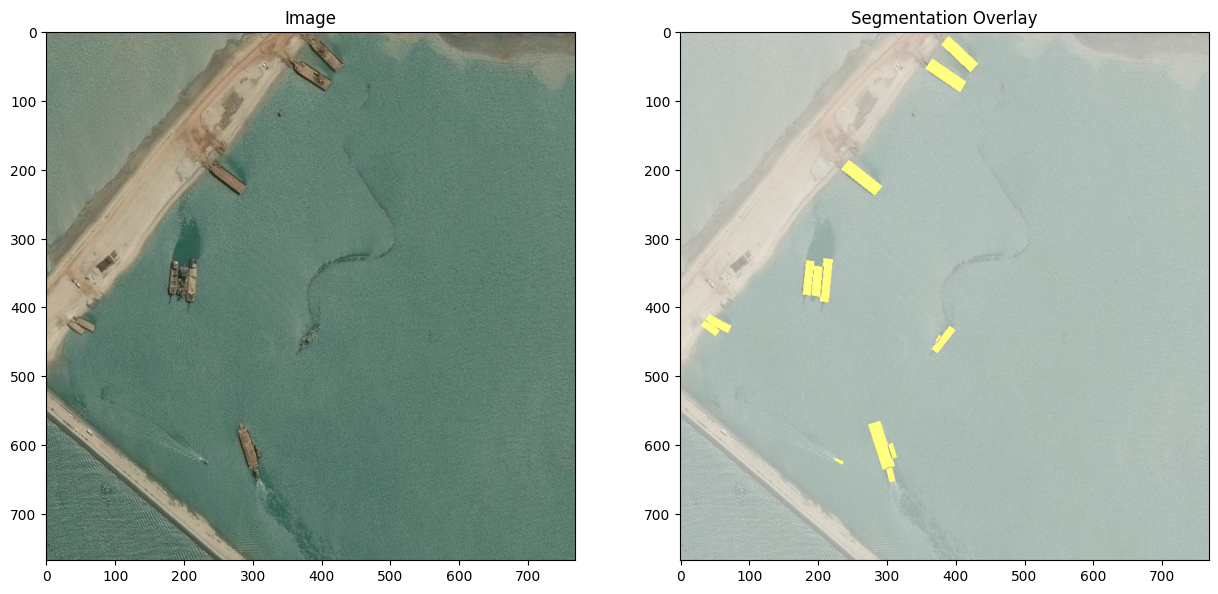

In [29]:
create_mask('0a1a7f395.jpg', ship_segmentations, train_dir)

##### Now we know how to work with dataset ...